In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
from bspline import Bspline, splinelab
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# RL initializations
alpha_coeff = 1.0 # learning rate coefficient

# Asset dynamics initialization
S0 = 100 # stock price at t=0
mu = 0.03 # drift
sig = 0.20 # vol.
r = 0.01 # rf
Mat = 1 # maturity
T = 30 # time steps
dt = Mat / T # interval length
paths = 2000 # number of paths

# Portfolio initializations
lambda_risk = 10.0 # risk aversion
gamma = np.exp(- r * dt) # discount term

<ipython-input-4-4b26a26bcdc0>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  S.loc[:, 0] = S0
<ipython-input-4-4b26a26bcdc0>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  S.loc[:, t] = S.loc[:, t - 1] * np.exp(


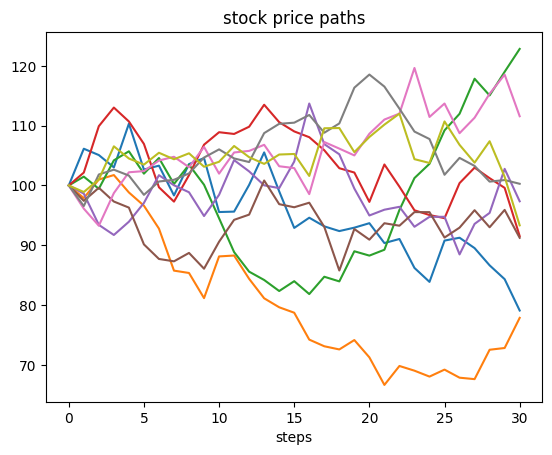

In [4]:
# Standard normal random numbers
RN = pd.DataFrame(np.random.randn(paths, T), index=range(1, paths + 1), columns=range(1, T + 1))

# Simulating a Geometric Brownian motion
S = pd.DataFrame([], index=range(1, paths + 1), columns=range(T + 1))
S.loc[:, 0] = S0
for t in range(1, T + 1):
    S.loc[:, t] = S.loc[:, t - 1] * np.exp(
        (mu - 1 / 2 * sig ** 2) * dt + sig * np.sqrt(dt) * RN.loc[:, t])

# plotting paths
step_d = paths // 10
indx_plot = np.arange(step_d, paths, step_d)
plt.plot(S.T.iloc[:, indx_plot])
plt.xlabel('steps')
plt.title('stock price paths')
plt.show()

In [5]:
#RL rewards (risk adjusted return)
def negative_reward(mu, V, a, rf, lambda_risk):
    C = - a * mu - (1-a) * rf + lambda_risk * (a ** 2) * V
    return C

X = S # some welath initialization

# Spline setup
p = 4 # B-spline order
ncolloc = 16 # defining collocation
a_minimum = -1
a_maximum = 1

In [6]:
def B_functions(X_min, X_max, a_min, a_max, ncolloc, p=3):
    tau_x = np.linspace(X_min, X_max, ncolloc)  # interpolation points
    tau_a = np.linspace(a_min, a_max, ncolloc)
    k_x = splinelab.aptknt(tau_x, p)
    k_a = splinelab.aptknt(tau_a, p)

    # basis: order - p, knots - k
    B_x = Bspline(k_x, p)
    B_a = Bspline(k_a, p)
    return B_x, B_a

time_steps = T + 1
Basis = ncolloc ** 2

mat_t = np.zeros((time_steps, paths, Basis))

x = X.values[:, 0]
np.shape(x)

def S_mat(t, mat_t):
    # matrix S
    mat_X = mat_t[t, :, :]
    num_basis_funcs = mat_X.shape[1]
    S = np.dot(mat_X.T, mat_X)
    return S

def M_vec(t, Q, R, mat_t, gamma=0.1):
    mat_X = mat_t[t, :, :]
    tmp = R + gamma * np.min(Q[:, t+1])  # note that the second argument in Q is t+1
    M = np.dot(mat_X.T, tmp)
    return M

In [7]:
mu = np.zeros(T)
var = np.zeros(T)

# optimal actions (theoretical and RL)
a_opt_RL = np.zeros((paths, T))
a_opt_star = pd.DataFrame([], index=range(1, paths + 1), columns=range(T + 1))
a_opt_star.iloc[:, -1] = 0

# optimal Q-function
Q_opt_star = np.zeros((paths, T))

a_mean = []

grd_size_x = 20
grd_size_a = 500

# basis functions support as a grid
a_min_p = a_minimum + 0.1
a_max_p = a_maximum - 0.1

a_grd = np.linspace(a_min_p, a_max_p, grd_size_a)

Q_star = np.zeros((paths, T))
tau = 1e-6
a = a_min_p + (a_max_p - a_min_p) * np.random.rand(paths)

<ipython-input-7-aa5cc361360a>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  a_opt_star.iloc[:, -1] = 0


In [8]:
for t in np.arange(T - 2, 0, -1):
    error = tau
    q_prv = np.zeros(paths)
    ret = (S.loc[:, t + 1] - S.loc[:, t]) / S.loc[:, t]
    mu[t] = np.mean(ret)
    var[t] = np.var(ret)
    count = 0
    max_iter = 100
    x = X.values[:, t]
    basis_x, basis_a = B_functions(np.min(x) - 10, np.max(x) + 10, a_minimum, a_maximum, ncolloc, p)
    x_grid = np.linspace(np.min(x), np.max(x), grd_size_x)
    phi_matrix = np.array([[np.kron(basis_x(x_grid[i]), basis_a(a_grd[j])).reshape(Basis, 1)
                            for i in range(grd_size_x)] for j in range(grd_size_a)])[:, :, :, 0]

    while (np.abs(error) >= tau) and (count < max_iter):

        R = negative_reward(mu[t], var[t], a, r, lambda_risk)
        mat_t[t, :, :] = np.array(
            [np.kron(basis_x(x[i]), basis_a(a[i])).reshape(Basis, 1) for i in range(paths)])[:, :, 0]

        # partition check
        h = np.dot(mat_t[t], np.ones(np.shape(mat_t[t])[1]))
        if np.sum(h) != paths:
            print("error: partition!")
        S_t = S_mat(t, mat_t)
        M_t = M_vec(t, Q_star, R, mat_t, gamma)
        W_t = np.dot(np.linalg.pinv(S_t), M_t)

        # Q_t matrix on finer grid
        # interpolating over the x * a  samller grid
        Q_t = np.dot(phi_matrix, W_t)  # Q_t on a grid

        print("error: ||Sw-M||")
        print(np.linalg.norm(np.dot(S_t, W_t) - M_t))

        # opt. action on a finer grid
        a_idx = np.argmin(Q_t, axis=0)
        a_star_ = np.zeros(grd_size_x, dtype='float64')

        for j in range(grd_size_x):
            a_star_[j] = a_grd[a_idx[j]]

        f = interp1d(x_grid, a_star_, kind='cubic')
        a_prm = f(x)

        # neg. reward is lower -> update
        R_prime = negative_reward(mu[t], var[t], a_prm, r, lambda_risk)
        idx = np.where(R_prime > R)
        a_prm[idx] = a[idx]
        a = a_prm
        a_mean.append(np.mean(a))
        Q_star[:, t] = np.dot(mat_t[t, :, :], W_t)
        error = np.linalg.norm(Q_star[:, t] - q_prv)

        q_prv = np.copy(Q_star[:, t])

        print('iter, Qerr, E[R], E[a]')
        print(count, error, np.mean(R), np.mean(a))
        count += 1

    a_opt_RL[:, t] = a

error: ||Sw-M||
6.739174641583041e-08
iter, Qerr, E[R], E[a]
0 0.3720002280306942 -0.006273607827750738 -0.31930862939652377
error: ||Sw-M||
0.0005142140610115666
iter, Qerr, E[R], E[a]
1 0.3335261795903004 -0.011351109953315924 -0.31930350612976766
error: ||Sw-M||
0.01452581133751208
iter, Qerr, E[R], E[a]
2 0.0014369475358714178 -0.01135113041821136 -0.3193052631473364
error: ||Sw-M||
0.0010540217268745623
iter, Qerr, E[R], E[a]
3 0.001374498469423731 -0.01135113877960399 -0.31934645886531626
error: ||Sw-M||
0.00044598623631267483
iter, Qerr, E[R], E[a]
4 0.00022035903211203628 -0.011351145612895217 -0.3193641850581532
error: ||Sw-M||
0.0010131560676692338
iter, Qerr, E[R], E[a]
5 0.00020763448893952347 -0.01135114588437911 -0.31943562592220487
error: ||Sw-M||
0.00020566558460953082
iter, Qerr, E[R], E[a]
6 0.000134481602324216 -0.011351146401703807 -0.31946455623034753
error: ||Sw-M||
0.00020348559853113792
iter, Qerr, E[R], E[a]
7 2.482098220420672e-05 -0.011351146658967932 -0.3194

In [18]:
a_theor_exact = []
a_RL_approx = []

for t in range(1, T - 1):
    a_theor_exact.append((mu[t] - r) / (2 * lambda_risk * var[t]))
    a_RL_approx.append(np.mean(a_opt_RL[:, t]))

Text(0, 0.5, 'action')

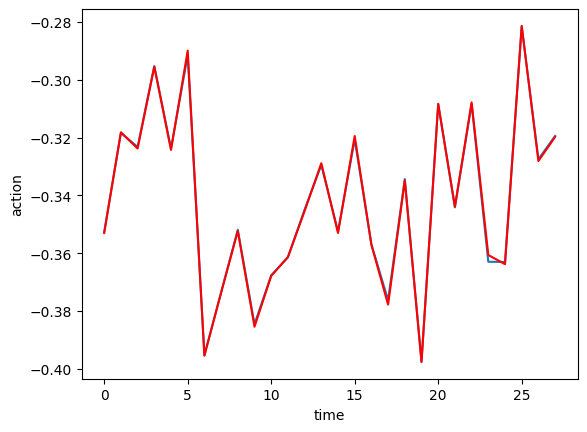

In [19]:
plt.plot(a_RL_approx)
plt.plot(a_theor_exact, color='red')
plt.xlabel('time')
plt.ylabel('action')

In [20]:
a_theor_exact = (mu[t] - r) / (2 * lambda_risk * var[t])

a_theor_exact

-0.3197972864612797

In [21]:
negative_reward(mu[t], var[t], a_theor_exact, r, lambda_risk)

tmp = np.arange(-1, 1, 0.01)

Text(0, 0.5, 'R')

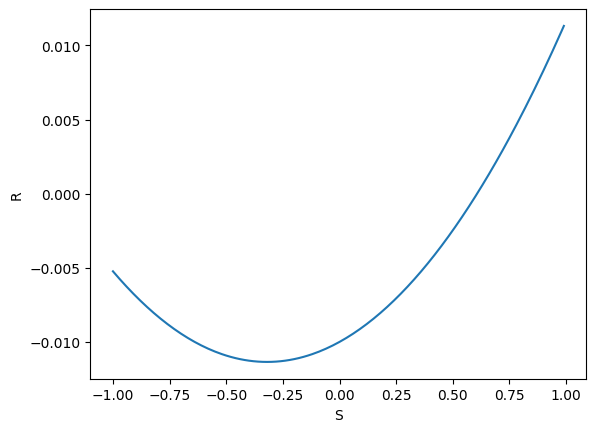

In [22]:
plt.plot(tmp, negative_reward(mu[t], var[t], tmp, r, lambda_risk))
plt.xlabel('S')
plt.ylabel('R')